# 1分足データの基本分析

- 上昇確率

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
from dateutil.relativedelta import relativedelta
import locale
from joblib import Parallel, delayed

import finalib as fl
import finalib.mine as mi
import ta

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

# データ読み込み

In [3]:
# 生データ
sp_dir = 'data/e-mini-sp500-200530'
df_sp_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-01min.csv')

# 月次データ（1年ごとの価格変化を見るため）
df_spm_raw = pd.read_csv(f'{sp_dir}/e-mini-sp500-monthly.csv')

# 分析用データ作成

In [4]:
df = df_sp_raw.copy()

# DateTimeインデックスにする
def to_datetime_idx(df):
    df['DT'] = (df['Date'] + '-' + df['Time']).map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y-%H:%M'))
    return df.set_index('DT')

df = to_datetime_idx(df)

# 値動き（終値 - 始値）列を追加
df['CODiff'] = df['Close'] - df['Open']

# 値動きの値はつなぎ足データの特性によって過去のデータほど小さい値になってしまうため、値動きの始値に対する割合を使用
df['CODiffPercent'] = df['CODiff'] / df['Open'] * 100

In [17]:
# 年の列を追加
df['year'] = df.index.map(lambda x: int(x.strftime('%Y')))

# 年の順序づけ
min_year = df['year'].min()
max_year = df['year'].max()
year_type = CategoricalDtype(categories=[y for y in range(min_year, max_year+1)], ordered=True)
df['year'] = df['year'].astype(year_type)

In [13]:
# 上昇、不変、下落
df['isUp'] = df['CODiff'] > 0
df['isFlat'] = df['CODiff'] == 0
df['isDown'] = df['CODiff'] < 0

### 年次データの作成（月次データを1年ごとに平均する）

In [14]:
dfm = df_spm_raw.copy()
dfm = to_datetime_idx(dfm)
dfm['year'] = dfm.index.map(lambda x: x.year)

dfm_by_year = dfm.groupby('year').mean()

# 全期間での1分足データの上昇確率

In [15]:
print(f"P(UP) = {df['isUp'].sum()} / {df.shape[0]} = {df['isUp'].sum() / df.shape[0] * 100}%")
print(f"P(FLAT) = {df['isFlat'].sum()} / {df.shape[0]} = {df['isFlat'].sum() / df.shape[0] * 100}%")
print(f"P(DOWN) = {df['isDown'].sum()} / {df.shape[0]} = {df['isDown'].sum() / df.shape[0] * 100}%")
df['isUp'].sum() + df['isFlat'].sum() + df['isDown'].sum() == df.shape[0]

P(UP) = 1996696 / 6596592 = 30.268599300972383%
P(FLAT) = 2609808 / 6596592 = 39.56297433583887%
P(DOWN) = 1990088 / 6596592 = 30.16842636318875%


True

# 1年ごとの上昇確率推移

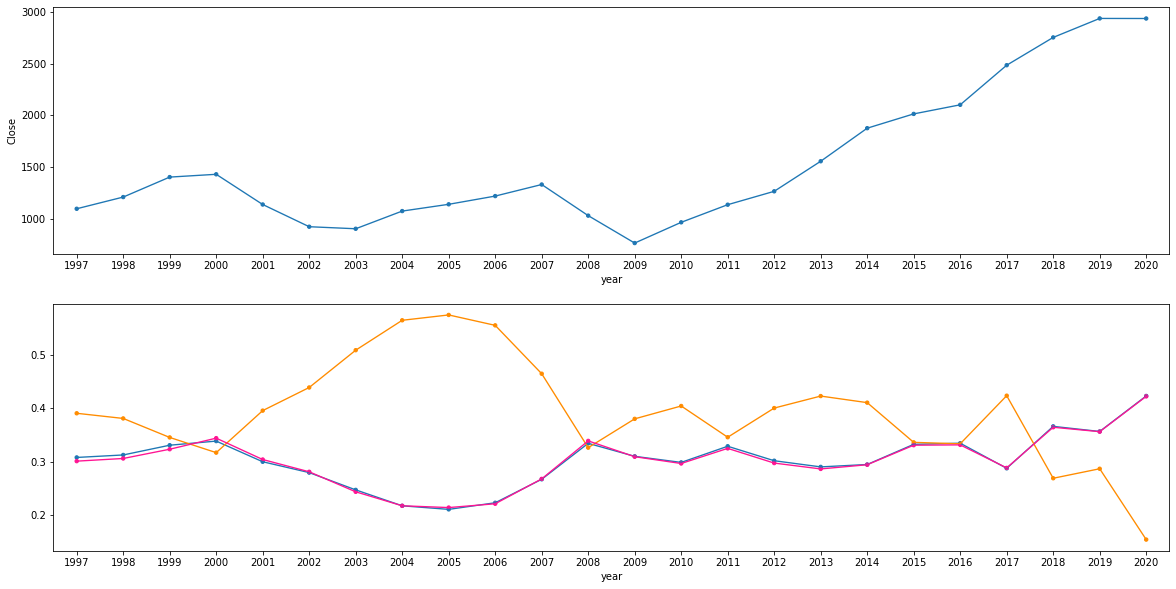

In [18]:
df_by_year = df.groupby('year')[['isUp', 'isFlat', 'isDown']].sum()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.pointplot(dfm_by_year.index, dfm_by_year['Close'], scale=0.5, ax=ax[0])
sns.pointplot(df_by_year.index, df_by_year['isUp'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1])
sns.pointplot(df_by_year.index, df_by_year['isFlat'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1], color='darkorange')
sns.pointplot(df_by_year.index, df_by_year['isDown'] / df['year'].value_counts().sort_index(), scale=0.5, ax=ax[1], color='deeppink')